<a href="https://colab.research.google.com/github/martell-n-tardy/Risk-Prediction-Models-for-Type-2-Diabetes/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMModel
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [57]:
#mount Drive and grant access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#read in data and save as variable df
df = pd.read_csv('/content/drive/MyDrive/SPRINGBOARD/CAPSTONE 3/BRFSS Data/Interim/manualfs_2015.csv')

In [120]:
df

,_STATE,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,BPMEDS,CHOLCHK,CVDINFR4,CVDCRHD4,CVDSTRK3,CHCSCNCR,CHCOCNCR,CHCCOPD1,ADDEPEV2,CHCKIDNY,DIABETE3,DIABAGE2,SEX,MARITAL,RENTHOM1,NUMHHOL2,CPDEMO1,VETERAN3,EMPLOY1,INTERNET,HEIGHT3,PREGNANT,QLACTLM2,USEEQUIP,BLIND,DECIDE,DIFFWALK,DIFFDRES,DIFFALON,STOPSMK2,LASTSMK2,USENOW3,...,_RFCHOL,_MICHD,_ASTHMS1,_DRDXAR1,_RACE,_AGEG5YR,HTIN4,_BMI5CAT,_CHLDCNT,_EDUCAG,_INCOMG,_SMOKER3,DROCDY3_,_DRNKWEK,_RFDRHV5,FTJUDA1_,FRUTDA1_,BEANDAY_,GRENDAY_,ORNGDAY_,VEGEDA1_,_FRTLT1,_VEGLT1,_TOTINDA,ACTIN11_,ACTIN21_,STRFREQ_,_PACAT1,_PAINDX1,_PA150R2,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_AIDTST3,TYPE2
0,1.0,15.0,18.0,10.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,3.0,99.0,2.0,1.0,1.0,2.0,1.0,2.0,8.0,2.0,510.0,9.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,9.0,2.0,3.0,...,2.0,2.0,1.0,1.0,1.0,9.0,70.0,4.0,1.0,2.0,2.0,3.0,5.397605e-79,5.397605e-79,1.0,1.700000e+01,3.300000e+01,6.700000e+01,3.300000e+01,17.0,100.0,2.0,1.0,2.0,9.0,9.000000e+00,5.397605e-79,4.0,2.0,3.0,3.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,0
1,1.0,88.0,88.0,99.0,2.0,1.0,1.0,4.0,9.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,99.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,1.0,508.0,9.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,99.0,3.0,...,1.0,2.0,3.0,2.0,1.0,7.0,68.0,3.0,1.0,4.0,1.0,1.0,5.397605e-79,5.397605e-79,1.0,7.000000e+00,1.700000e+01,7.000000e+00,2.900000e+01,29.0,13.0,2.0,2.0,1.0,1.0,5.397605e-79,5.397605e-79,2.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0,2.0,2.0,0
2,1.0,15.0,88.0,88.0,1.0,2.0,2.0,1.0,9.0,1.0,7.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,3.0,99.0,2.0,2.0,1.0,2.0,1.0,2.0,7.0,2.0,511.0,9.0,2.0,2.0,2.0,2.0,9.0,9.0,9.0,9.0,99.0,9.0,...,2.0,9.0,3.0,1.0,1.0,11.0,71.0,2.0,1.0,2.0,9.0,9.0,9.000000e+02,9.990000e+04,9.0,9.999000e+04,9.999000e+04,9.999000e+04,9.999000e+04,99990.0,99990.0,9.0,9.0,9.0,9.0,9.000000e+00,9.900000e+04,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,0
3,1.0,30.0,30.0,30.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,99.0,2.0,1.0,1.0,2.0,1.0,2.0,8.0,2.0,507.0,9.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,9.0,99.0,3.0,...,2.0,2.0,3.0,1.0,1.0,9.0,67.0,3.0,2.0,2.0,5.0,4.0,5.397605e-79,5.397605e-79,1.0,5.397605e-79,1.000000e+02,5.397605e-79,3.000000e+00,3.0,14.0,1.0,2.0,2.0,9.0,9.000000e+00,5.397605e-79,4.0,2.0,3.0,3.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,9.0,0
4,1.0,20.0,88.0,30.0,1.0,1.0,2.0,1.0,9.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,99.0,2.0,1.0,1.0,2.0,2.0,2.0,8.0,1.0,504.0,9.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,9.0,99.0,3.0,...,1.0,2.0,3.0,1.0,1.0,9.0,64.0,2.0,1.0,3.0,9.0,4.0,5.397605e-79,5.397605e-79,1.0,9.999000e+04,2.000000e+02,4.300000e+01,5.700000e+01,33.0,67.0,9.0,1.0,2.0,9.0,9.000000e+00,5.397605e-79,4.0,2.0,3.0,3.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,72.0,88.0,88.0,99.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,55.0,2.0,3.0,1.0,9.0,9.0,2.0,7.0,2.0,503.0,9.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,9.0,99.0,3.0,...,2.0,2.0,3.0,1.0,8.0,11.0,63.0,1.0,1.0,1.0,2.0,4.0,5.397605e-79,5.397605e-79,1.0,2.900000e+01,5.397605e-79,7.100000e+01,5.397605e-79,14.0,14.0,2.0,2.0,2.0,9.0,9.000000e+00,5.397605e-79,4.0,2.0,3.0,3.0,2.0,2.0,4.0,2.0,2.0,3.0,1.0,2.0,1
441452,72.0,88.0,88.0,99.0,1.0,1.0,2.0,1.0,9.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,99.0,2.0,1.0,1.0,9.0,9.0,2.0,1.0,1.0,503.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,9.0,99.0,3.0,...,1.0,2.0,3.0,2.0,8.0,2.0,63.0,3.0,2.0,3.0,1.0,4.0,5.397605e-79,5.397605e-79,1.0,1.700000e+01,1.000000e+02,2.900000e+01,1.000000e+01,14.0,29.0,1.0,2.0,1.0,1.0,5.397605e-79,5.397605e-79,2.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0,1.0,1.0,0
441453,72.0,88.0,20.0,88.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,99.0,2.0,1.0,1.0,9.0,9.0,2.0,7.0,2.0,5

Now, let's confirm again there are no null values in this dataset.

In [121]:
df.columns[df.isnull().any()]

Index([], dtype='object')

There are no null values. Otherwise the column name would be returned. 

Now, let's turn this into a binary classification problem. Meaning, the survey participants are either diabetic or not diabetic. Those who are diabetic have already been identified and saved in dataset as feature `TYPE2` equal to the value 1.

# Final feature reduction

The LightGBM method that will be used is the traditional Gradient Boosting Decision Tree (GBDT). This method is based on three important principles: weak learners (decision trees), gradient optimization, and boosting technique. 

## preparing the data

In [105]:
#copy of df as appropriate type for LightGBM
df1 = df

#split data into X and y
X,y = df1.drop(['TYPE2','DIABETE3'], axis = 1), df1['TYPE2']
#split data 70/30 train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Use test subset for early stopping criterion to avoid overtraining and we do not need to optimise the number of trees.

## LGBMClassifier

In [106]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

Create a model

In [113]:
model_lgb = lgb.LGBMClassifier(num_leaves= 15, max_depth=1,  
                         silent=True, 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1,
                         objective = 'binary',
                         random_state = 314)

Train the model. 

In [114]:
model_lgb.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_logloss: 0.00559703	valid's auc: 0.999376
[200]	valid's binary_logloss: 0.00368912	valid's auc: 0.999717
Early stopping, best iteration is:
[246]	valid's binary_logloss: 0.00331521	valid's auc: 0.999782


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
               importance_type='split', learning_rate=0.1, max_depth=1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=4, num_leaves=15, objective='binary',
               random_state=314, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

plot feature importance

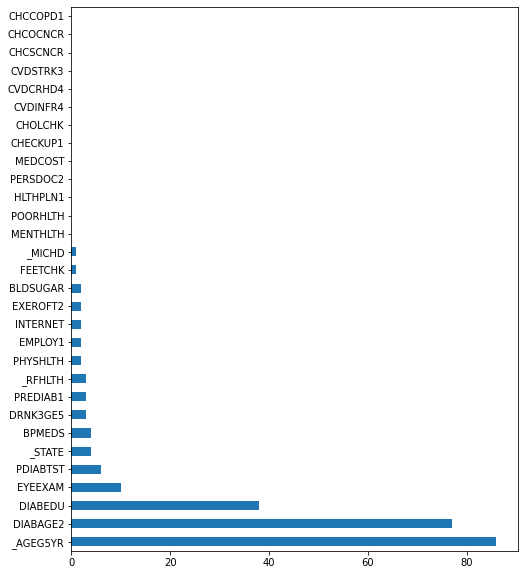

In [115]:
feat_imp = pd.Series(model_lgb.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

## LGBMREgressor

In [118]:
model_reg = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=31, max_depth =8)
model_reg.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[29]	valid's auc: 0.999724	valid's l2: 0.000620933


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

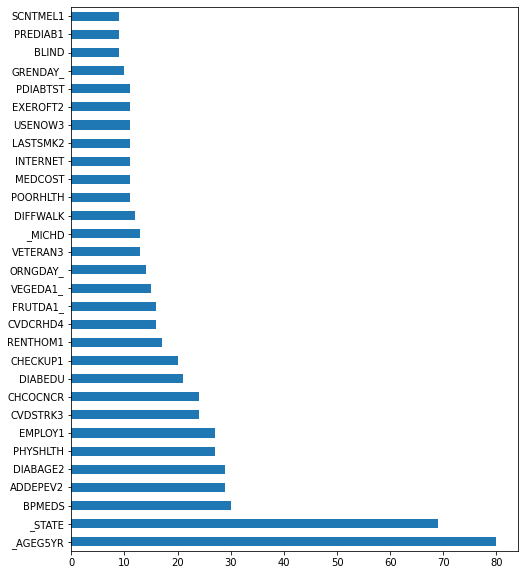

In [119]:
feat_imp = pd.Series(model_reg.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))